#Final B4 - Grupo 1 - Entrenamiento de Modelos de Machine Learning

Análisis de DF de clientes de IPTV para detectar bajas en un período de dos meses aplicando modelos predictivos.

Integrantes:



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta,date
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV


### **Funciones a utilizar**



In [2]:
def ThresholdOptimo(y_test_pb, y_test):
  """
    Función Threshold Optimo
    Evalúa a qué threshold se genera la mayor ganancia y devuelve dichos valores.
    INPUT:
     y_test_pb: array de probabilidades generado por el modelo a evaluar
     y_test: array con resultado de clase real
    OUTPUT:
     Ganancia Máxima, Threshold
  """  
  import pandas as pd
  
  # Los array recibidos se cargan en DF y se arma un DF total
  dfp = pd.DataFrame(y_test_pb)
  dfy = pd.DataFrame(y_test)
  dfy = dfy.reset_index()
  dfy = dfy.drop(['index'], axis=1)
  dfpmodelo = pd.concat([dfy, dfp], axis=1)
  dfpmodelo.columns = ['Clase', 'Probabilidad']
  # Se genera una columna Ganancia
  dfpmodelo['Ganancia'] = 0

  # Ordeno la columna de probabilidad de mayor a menor
  dfpmodelo = dfpmodelo.sort_values('Probabilidad', ascending=False)
  dfpmodelo = dfpmodelo.reset_index()

  # Se llena la columna Ganancia sumando la ganacia de cada registro:
  # Si la Clase = 1 suma 4900, Clase = 0 resta 100
  ganacum = 0
  for i in dfpmodelo.index:
    if dfpmodelo['Clase'][i] == 1:
      gan = 4900
    else:
      gan = -100
    ganacum = ganacum + gan
    #dfpmodelo['Ganancia'][i] = ganacum
    dfpmodelo.loc[i,['Ganancia']] = ganacum

  # Ordeno la columna de Ganancia de mayor a menor y tomo el valor mayor
  dfpmodelo = dfpmodelo.sort_values('Ganancia', ascending=False).head(1)
  dfpmodelo = dfpmodelo.reset_index()
  ganancia = dfpmodelo['Ganancia'][0]
  threshold = dfpmodelo['Probabilidad'][0]

  return (ganancia, threshold)


In [3]:
def Dibujar_CurvaROC(fpr,tpr,titulo):
    # Plot ROC curves
    plt.subplots(1, figsize=(4, 4))
    plt.title(titulo, fontsize=14, fontweight="bold")
    plt.plot(fpr_test1, tpr_test1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.show()

In [4]:
def Dibujar_Distribucion(elementosUnicos, cantidadElementos):
   
    plt.rcParams["figure.figsize"] = (4.3,1.2)

    fig1, ax1 = plt.subplots()

    # Función que crea las cadenas a usar como etiquetas
    def formatear(index, value, total):
      return f" {index} {value} ({value/total*100:.2f}%)"

    h=ax1.barh(y=elementosUnicos, width=cantidadElementos, height=0, align='center', 
        tick_label=['0','1'], color=['Blue','Orange'], label=unique_elements)

    # Poner etiquetas
    total = sum(cantidadElementos)
    labels=[]
    for index, value in enumerate(cantidadElementos.tolist()):     
        labels.append(formatear(index, value, total))
        #plt.text(value, index, formatear(index, value, total), fontdict=font, va="center", ha="left")

    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    plt.axhline(y=1.4, xmin=0, xmax=1000)

    plt.title("Comprobación de distribución de clases")

    plt.legend(h,labels, loc='upper center',fontsize=16)

    plt.show

In [5]:
LOGR_LABELS = ['SE QUEDA', 'SE VA']

def Dibujar_MatrizConfusion(y_test, pred_y):
    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns 
    from sklearn.metrics import confusion_matrix
    
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, xticklabels=LOGR_LABELS, yticklabels=LOGR_LABELS, annot=True, fmt="d",cbar=False);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

# **Carga DF preprocesado**


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# df = pd.read_csv('./sample_data/DFTotal.csv')

path = '/content/drive/My Drive/B4/TPFinal/ML'
df2 = pd.read_csv(path + '/DFTotal.csv')


In [8]:
df2.head()

,foto_mes,NumeroCliente,ServicioIPTV,PersonaFisica,CuentaRefinanciada,ServicioHabilitado,Saldo,DebitoAutomatico,CantidadReclamos,MesesServicio,MesesCliente,PaqueteHBO,PaqueteHD,PaqueteAdultos,PaqueteFutbol,TieneBonificacion,CantOtrosServMismoLote,CantOtrosServOtroLote,target_bin
0,202105,50016,537453,1,0,1,0.00,0,1,49.57,441.37,0,0,0,0,1,3,5,0
1,202105,50016,672504,1,0,1,0.00,0,0,22.52,441.37,0,1,0,0,0,4,4,0
2,202105,50024,433890,1,0,1,0.17,1,0,73.25,405.40,0,1,0,0,0,2,4,0
3,202105,50125,455362,1,0,1,0.00,1,0,68.06,429.61,0,1,0,0,0,1,0,0
4,202105,50157,505289,1,0,1,0.00,0,0,53.77,428.46,0,0,0,0,0,3,0,0


In [9]:
# Elimino las primeras 3 columnas (no relevantes para el análisis)
df2 = df2.drop(['foto_mes' , 'NumeroCliente', 'ServicioIPTV'] , axis='columns')
df2.head()


,PersonaFisica,CuentaRefinanciada,ServicioHabilitado,Saldo,DebitoAutomatico,CantidadReclamos,MesesServicio,MesesCliente,PaqueteHBO,PaqueteHD,PaqueteAdultos,PaqueteFutbol,TieneBonificacion,CantOtrosServMismoLote,CantOtrosServOtroLote,target_bin
0,1,0,1,0.00,0,1,49.57,441.37,0,0,0,0,1,3,5,0
1,1,0,1,0.00,0,0,22.52,441.37,0,1,0,0,0,4,4,0
2,1,0,1,0.17,1,0,73.25,405.40,0,1,0,0,0,2,4,0
3,1,0,1,0.00,1,0,68.06,429.61,0,1,0,0,0,1,0,0
4,1,0,1,0.00,0,0,53.77,428.46,0,0,0,0,0,3,0,0


In [10]:
print(df2.shape)


(19034, 16)


### **Creamos los set de train y test**

In [11]:
X = df2.drop(['target_bin'] , axis='columns')
y = df2.target_bin

print(X.shape)
print(y.shape)

(19034, 15)
(19034,)


In [12]:
# Tomo X y de Creamos los set de train y test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)


(14275, 15)
(4759, 15)


In [13]:
y_train.value_counts()


0    13872
1      403
Name: target_bin, dtype: int64

In [14]:
y_test.value_counts()


0    4610
1     149
Name: target_bin, dtype: int64

Comprobamos distribución sobre el conjunto de datos

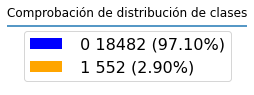

In [15]:
unique_elements, counts_elements = np.unique(y, return_counts=True)
Dibujar_Distribucion(unique_elements, counts_elements)

Claramente se aprecia que el conjunto de datos se encuentra desbalanceado, siendo la clase minoritaria, 
la necesaria a detectar.

# **Regresión Logística**

#### Validación cruzada a utilizar

In [16]:
LOGR_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#### Algoritmo a utilizar

In [17]:
algoritmos = {'LOGR': LogisticRegression(solver='saga', random_state=1, penalty='l2')}

## **Datos no balanceados (Modelo base)**

Estandarización de datos de entrenamiento

In [18]:
standardizer = StandardScaler()
X_train_stdr = standardizer.fit_transform(X_train)

Búsqueda de parámetros óptimos

In [19]:
LOGR_param_grid = {
                   'C':[0.0001, 0.001, 0.01, 0.1],
                   'max_iter':[100, 1000, 2000]
                  }

LOGR_model_no_bal = GridSearchCV(estimator=algoritmos['LOGR'],
                           param_grid=LOGR_param_grid,
                           scoring='roc_auc',
                           cv=LOGR_cv,
                           n_jobs=-1)

LOGR_model_no_bal.fit(X_train_stdr, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(random_state=1, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'max_iter': [100, 1000, 2000]},
             scoring='roc_auc')

In [20]:
print ('Best Score: {:.2f}', LOGR_model_no_bal.best_score_)

Best Score: {:.2f} 0.6896681729554597


In [21]:
LOGR_model_no_bal.best_params_

{'C': 0.1, 'max_iter': 1000}

## **Regresión Logística - Modelo 1 - Datos sin balancear**

In [22]:
lr1=LOGR_model_no_bal.best_estimator_

Estandarización de datos de prueba

In [23]:
standardizer = StandardScaler()
X_test_stdr = standardizer.fit_transform(X_test)

In [24]:
y_train_pb1 = lr1.predict_proba(X_train_stdr)[:,1]
y_test_pb1 = lr1.predict_proba(X_test_stdr)[:,1]

y_train_pred1 = lr1.predict(X_train_stdr)
y_test_pred1 = lr1.predict(X_test_stdr)

print("AUC Train: {:.4f}\nAUC Test:  {:.4f} \n".format(roc_auc_score(y_train, y_train_pb1),
                                                    roc_auc_score(y_test, y_test_pb1)))

print('Accuracy:  Train: %.4f - Test: %.4f' % (accuracy_score(y_train, y_train_pred1), accuracy_score(y_test, y_test_pred1)))
print('Recall:    Train: %.4f - Test: %.4f' % (recall_score(y_train, y_train_pred1, average='weighted', labels=np.unique(y_train_pred1)), recall_score(y_test, y_test_pred1, average='weighted', labels=np.unique(y_test_pred1))))
print('Precision: Train: %.4f - Test: %.4f' % (precision_score(y_train, y_train_pred1, average='weighted', labels=np.unique(y_train_pred1)), precision_score(y_test, y_test_pred1, average='weighted', labels=np.unique(y_test_pred1))))

AUC Train: 0.7043
AUC Test:  0.6463 

Accuracy:  Train: 0.9718 - Test: 0.9687
Recall:    Train: 1.0000 - Test: 1.0000
Precision: Train: 0.9718 - Test: 0.9687


**Comprobamos que tan buena fue la clasificación**

In [25]:
set(y_test) - set(y_test_pred1)

{1}

In [26]:
print(len(y_test_pred1))
print(y_test.count())

4759
4759


In [27]:
print(np.unique(y_test_pred1))
np.unique(y_test)

[0]


array([0, 1])

Como se ve se tienen datos demasiados desequilibrados y se presentan problemas en el Recall y Precision.
<br> Todos las ys tienen una etiqueta predicha (4759), pero no todas las etiquetas fueron predichas al menos una vez (Falta la clase 1).

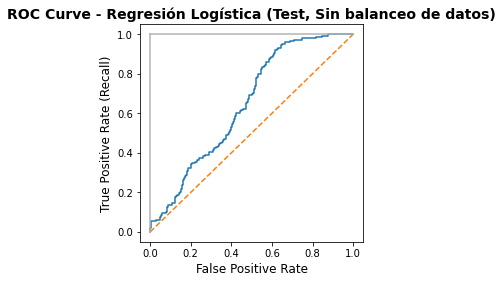

In [28]:
fpr_test1, tpr_test1, threshold1 = roc_curve(y_test, y_test_pb1)
titulo='ROC Curve - Regresión Logística (Test, Sin balanceo de datos)'
Dibujar_CurvaROC(fpr_test1, tpr_test1, titulo)


Ganancia Estimada: 395300 
Threshold: 0.0182



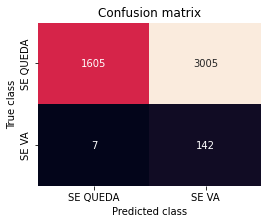

              precision    recall  f1-score   support

           0       1.00      0.35      0.52      4610
           1       0.05      0.95      0.09       149

    accuracy                           0.37      4759
   macro avg       0.52      0.65      0.30      4759
weighted avg       0.97      0.37      0.50      4759



In [29]:
ganancia, threshold = ThresholdOptimo(y_test_pb1, y_test)
print('\nGanancia Estimada: %.0f \nThreshold: %.4f\n' % (ganancia, threshold))

# Veo la matriz de confusión para el Threshlod seleccionado
# En y_test_pb1 = LOGR_model_no_bal.predict_proba(X_test)[:,1] tenemos la probabilidad
y_test_pp1 = (y_test_pb1 >= threshold).astype(bool)

Dibujar_MatrizConfusion(y_test, y_test_pp1)

In [30]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb1)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProb_RLOG_SB.xlsx')

In [31]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(LOGR_model_no_bal, path + '/RLOG_SB.joblib') 

['/content/drive/My Drive/B4/TPFinal/ML/RLOG_SB.joblib']

**Conclusión Regresión Logística - Modelo 1**

Viendo la Curva ROC y con un AUC-ROC en Test de 0,6463 no es un modelo aceptable ni apto para nuestra clasificación.

Ganancia Estimada: 395.300 - Threshold: 0,0182

## **Datos balanceados (under-sampling)**

Se aplica la técnica de submuestreo de centroides (internamente usa K-Means). Es tremendamente efectivo en términos de reducir la cantidad de FN, pero sube mucho los FP. En términos de ganancia tal vez convenga.

In [32]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_train_resampled, y_train_resampled = cc.fit_resample(X_train, y_train)

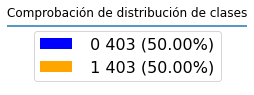

In [33]:
unique_elements, counts_elements = np.unique(y_train_resampled, return_counts=True)
Dibujar_Distribucion(unique_elements, counts_elements)

Estandarización de datos de entrenamiento

In [34]:
standardizer = StandardScaler()
X_train_stdr = standardizer.fit_transform(X_train_resampled)

Búsqueda de parámetros óptimos

In [35]:
LOGR_param_grid = {
                   'C':[0.0001, 0.001, 0.01, 0.1],
                   'max_iter':[100, 1000, 2000, 4000]
                  }

LOGR_model_bal = GridSearchCV(estimator=algoritmos['LOGR'],
                           param_grid=LOGR_param_grid,
                           scoring='roc_auc',
                           cv=LOGR_cv,
                           n_jobs=-1)

LOGR_model_bal.fit(X_train_stdr, y_train_resampled)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(random_state=1, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'max_iter': [100, 1000, 2000, 4000]},
             scoring='roc_auc')

In [36]:
print ('Best Score: {:.2f}', LOGR_model_bal.best_score_)

Best Score: {:.2f} 0.891699436061576


In [37]:
LOGR_model_bal.best_params_

{'C': 0.1, 'max_iter': 100}

## **Regresión Logística - Modelo 2 - Datos balanceados (Under Sampling)**

In [38]:
lr2=LOGR_model_bal.best_estimator_

Estandarización de datos de prueba

In [39]:
standardizer = StandardScaler()
X_test_stdr = standardizer.fit_transform(X_test)

In [40]:
y_train_pb2 = lr2.predict_proba(X_train_stdr)[:,1]
y_test_pb2 = lr2.predict_proba(X_test_stdr)[:,1]

y_train_pred2 = lr2.predict(X_train_stdr)
y_test_pred2 = lr2.predict(X_test_stdr)

print("AUC Train: {:.4f}\nAUC Test:  {:.4f} \n".format(roc_auc_score(y_train_resampled, y_train_pb2),
                                                    roc_auc_score(y_test, y_test_pb2)))

print('Accuracy:  Train: %.4f - Test: %.4f' % (accuracy_score(y_train_resampled, y_train_pred2), accuracy_score(y_test, y_test_pred2)))
print('Recall:    Train: %.4f - Test: %.4f' % (recall_score(y_train_resampled, y_train_pred2), recall_score(y_test, y_test_pred2)))
print('Precision: Train: %.4f - Test: %.4f' % (precision_score(y_train_resampled, y_train_pred2), precision_score(y_test, y_test_pred2)))

AUC Train: 0.9024
AUC Test:  0.5935 

Accuracy:  Train: 0.8313 - Test: 0.4677
Recall:    Train: 0.8536 - Test: 0.7315
Precision: Train: 0.8171 - Test: 0.0419


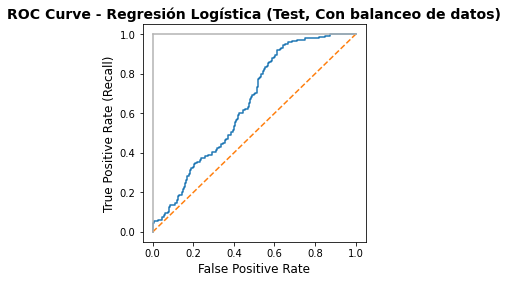

In [41]:
fpr_test2, tpr_test2, threshold2 = roc_curve(y_test, y_test_pb2)
titulo2='ROC Curve - Regresión Logística (Test, Con balanceo de datos)'
Dibujar_CurvaROC(fpr_test1, tpr_test1, titulo2)


Ganancia Estimada: 297000 
Threshold: 0.5320



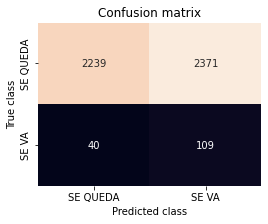

              precision    recall  f1-score   support

           0       0.98      0.49      0.65      4610
           1       0.04      0.73      0.08       149

    accuracy                           0.49      4759
   macro avg       0.51      0.61      0.37      4759
weighted avg       0.95      0.49      0.63      4759



In [42]:
ganancia, threshold = ThresholdOptimo(y_test_pb2, y_test)
print('\nGanancia Estimada: %.0f \nThreshold: %.4f\n' % (ganancia, threshold))

# Veo la matriz de confusión para el Threshlod seleccionado
# En y_test_pb1 = LOGR_model_no_bal.predict_proba(X_test)[:,1] tenemos la probabilidad
y_test_pp2 = (y_test_pb2 >= threshold).astype(bool)

Dibujar_MatrizConfusion(y_test, y_test_pp2)

In [43]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb2)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProb_RLOG_Bal.xlsx')

In [44]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(LOGR_model_bal, path + '/RLOG_Bal.joblib') 

['/content/drive/My Drive/B4/TPFinal/ML/RLOG_Bal.joblib']

**Conclusión Regresión Logística - Modelo 2**

Viendo la Curva ROC y con un AUC-ROC en Test de 0,5944 no es un modelo apto ni aceptable para nuestra clasificación.

Ganancia Estimada: 297.100 - Threshold: 0,5465

## **Datos balanceados (over-sampling)**

In [45]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_resampled_2, y_train_resampled_2 = smote.fit_resample(X_train, y_train)

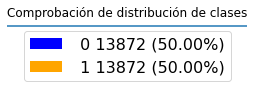

In [46]:
unique_elements, counts_elements = np.unique(y_train_resampled_2, return_counts=True)
Dibujar_Distribucion(unique_elements, counts_elements)

Estandarización de datos de entrenamiento

In [47]:
standardizer = StandardScaler()
X_train_stdr_2 = standardizer.fit_transform(X_train_resampled_2)

Búsqueda de parámetros óptimos

In [48]:
LOGR_param_grid = {
                   'C':[0.0001, 0.001, 0.01, 0.1],                   
                   'max_iter':[100, 1000, 2000, 4000]
                  }

LOGR_model_bal_2 = GridSearchCV(estimator=algoritmos['LOGR'],
                           param_grid=LOGR_param_grid,
                           scoring='roc_auc',
                           cv=LOGR_cv,
                           n_jobs=-1)

LOGR_model_bal_2.fit(X_train_stdr_2, y_train_resampled_2)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(random_state=1, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'max_iter': [100, 1000, 2000, 4000]},
             scoring='roc_auc')

In [49]:
print ('Best Score: {:.2f}', LOGR_model_bal_2.best_score_)

Best Score: {:.2f} 0.8050717565081598


In [50]:
LOGR_model_bal_2.best_params_

{'C': 0.1, 'max_iter': 1000}

## **Regresión Logística - Modelo 3 - Datos balanceados (Over Sampling)**

In [51]:
lr3=LOGR_model_bal_2.best_estimator_

Estandarización de datos de prueba

In [52]:
standardizer = StandardScaler()
X_test_stdr_2 = standardizer.fit_transform(X_test)

In [53]:
y_train_pb3 = lr3.predict_proba(X_train_stdr_2)[:,1]  #Con resample
y_test_pb3 = lr3.predict_proba(X_test_stdr_2)[:,1]    #Sin resample

y_train_pred3 = lr3.predict(X_train_stdr_2)
y_test_pred3 = lr3.predict(X_test_stdr_2)

print("AUC Train: {:.4f}\nAUC Test:  {:.4f} \n".format(roc_auc_score(y_train_resampled_2, y_train_pb3),
                                                    roc_auc_score(y_test, y_test_pb3)))

print('Accuracy:  Train: %.4f - Test: %.4f' % (accuracy_score(y_train_resampled_2, y_train_pred3), accuracy_score(y_test, y_test_pred3)))
print('Recall:    Train: %.4f - Test: %.4f' % (recall_score(y_train_resampled_2, y_train_pred3), recall_score(y_test, y_test_pred3)))
print('Precision: Train: %.4f - Test: %.4f' % (precision_score(y_train_resampled_2, y_train_pred3), precision_score(y_test, y_test_pred3)))

AUC Train: 0.8059
AUC Test:  0.5869 

Accuracy:  Train: 0.7215 - Test: 0.4692
Recall:    Train: 0.7676 - Test: 0.7114
Precision: Train: 0.7028 - Test: 0.0409


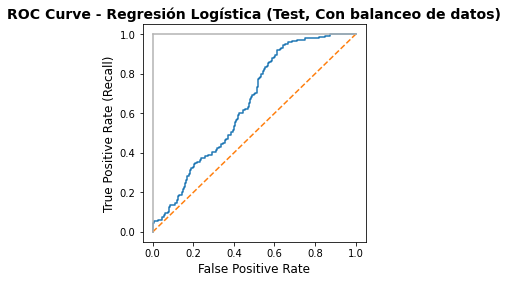

In [54]:
fpr_test3, tpr_test3, threshold3 = roc_curve(y_test, y_test_pb3)
titulo3=f'ROC Curve - Regresión Logística (Test, Con balanceo de datos)'
Dibujar_CurvaROC(fpr_test3, tpr_test3, titulo3)


Ganancia Estimada: 297200 
Threshold: 0.0965



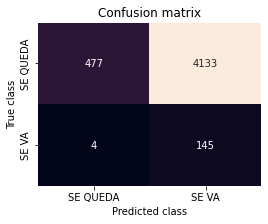

              precision    recall  f1-score   support

           0       0.99      0.10      0.19      4610
           1       0.03      0.97      0.07       149

    accuracy                           0.13      4759
   macro avg       0.51      0.54      0.13      4759
weighted avg       0.96      0.13      0.18      4759



In [55]:
ganancia, threshold = ThresholdOptimo(y_test_pb3, y_test)
print('\nGanancia Estimada: %.0f \nThreshold: %.4f\n' % (ganancia, threshold))

# Veo la matriz de confusión para el Threshlod seleccionado
# En y_test_pb1 = LOGR_model_no_bal.predict_proba(X_test)[:,1] tenemos la probabilidad
y_test_pp3 = (y_test_pb3 >= threshold).astype(bool)

Dibujar_MatrizConfusion(y_test, y_test_pp3)

In [56]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb3)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProb_RLOG_Bal2.xlsx')

In [57]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(lr3, path + '/RLOG_Bal2.joblib') 

['/content/drive/My Drive/B4/TPFinal/ML/RLOG_Bal2.joblib']

**Conclusión Regresión Logística - Modelo 3**

Viendo la Curva ROC y con un AUC-ROC en Test de 0,5875 no es un modelo apto para nuestra clasificación.

Ganancia Estimada: 298.800 - Threshold: 0,0882

## **Prueba solo las columnas más significativas (según Random Forest)**

Aclaración: el Random Forest que justifica la importancia de las columnas tomadas para esta ejecución se encuentra en otro análisis de modelo dentro del mismo trabajo final. (Véase: Feature Importance)

In [58]:
X2=df2[['MesesCliente','MesesServicio','Saldo','ServicioHabilitado','CantOtrosServMismoLote','CantOtrosServOtroLote','CantidadReclamos']].copy()

In [59]:
print(X2.shape)
print(y.shape)

(19034, 7)
(19034,)


Realizamos el over sampling

In [60]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_resampled_3, y_train_resampled_3 = smote.fit_resample(X_train, y_train)

Comprobamos distribución sobre el conjunto de datos

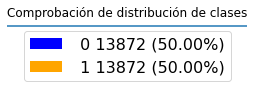

In [61]:
unique_elements, counts_elements = np.unique(y_train_resampled_3, return_counts=True)
Dibujar_Distribucion(unique_elements, counts_elements)

Estandarización de datos de entrenamiento

In [62]:
standardizer = StandardScaler()
X_train_stdr_3 = standardizer.fit_transform(X_train_resampled_3)

Búsqueda de parámetros óptimos

In [63]:
LOGR_param_grid = {
                   'C':[0.0001, 0.001, 0.01, 0.1],                   
                   'max_iter':[100, 1000, 2000, 4000]
                  }

LOGR_model_bal_3 = GridSearchCV(estimator=algoritmos['LOGR'],
                           param_grid=LOGR_param_grid,
                           scoring='roc_auc',
                           cv=LOGR_cv,
                           n_jobs=-1)

LOGR_model_bal_3.fit(X_train_stdr_3, y_train_resampled_3)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(random_state=1, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'max_iter': [100, 1000, 2000, 4000]},
             scoring='roc_auc')

In [64]:
print ('Best Score: {:.2f}', LOGR_model_bal_3.best_score_)

Best Score: {:.2f} 0.8009735205841869


In [65]:
LOGR_model_bal_3.best_params_

{'C': 0.1, 'max_iter': 1000}

## **Regresión Logística - Modelo 4 - Datos balanceados (Over Sampling)**

In [66]:
lr4=LOGR_model_bal_3.best_estimator_

Estandarización de datos de prueba

In [67]:
standardizer = StandardScaler()
X_test_stdr_3 = standardizer.fit_transform(X_test)

In [68]:
y_train_pb4 = lr4.predict_proba(X_train_stdr_3)[:,1]  #Con resample
y_test_pb4 = lr4.predict_proba(X_test_stdr_3)[:,1]    #Sin resample

y_train_pred4 = lr4.predict(X_train_stdr_3)
y_test_pred4 = lr4.predict(X_test_stdr_3)

print("AUC Train: {:.4f}\nAUC Test:  {:.4f} \n".format(roc_auc_score(y_train_resampled_3, y_train_pb4),
                                                    roc_auc_score(y_test, y_test_pb4)))

print('Accuracy:  Train: %.4f - Test: %.4f' % (accuracy_score(y_train_resampled_3, y_train_pred4), accuracy_score(y_test, y_test_pred4)))
print('Recall:    Train: %.4f - Test: %.4f' % (recall_score(y_train_resampled_3, y_train_pred4), recall_score(y_test, y_test_pred4)))
print('Precision: Train: %.4f - Test: %.4f' % (precision_score(y_train_resampled_3, y_train_pred4), precision_score(y_test, y_test_pred4)))

AUC Train: 0.8017
AUC Test:  0.5874 

Accuracy:  Train: 0.7208 - Test: 0.4659
Recall:    Train: 0.7708 - Test: 0.7114
Precision: Train: 0.7008 - Test: 0.0407


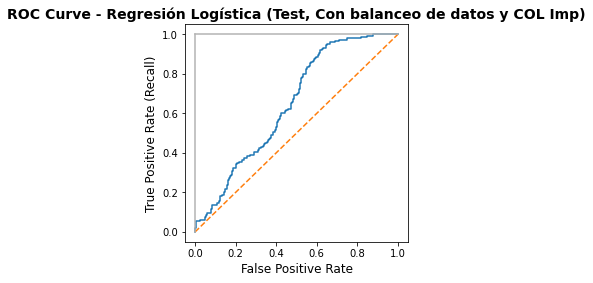

In [69]:
fpr_test4, tpr_test4, threshold4 = roc_curve(y_test, y_test_pb4)
titulo4=f'ROC Curve - Regresión Logística (Test, Con balanceo de datos y COL Imp)'
Dibujar_CurvaROC(fpr_test4, tpr_test4, titulo4)


Ganancia Estimada: 297000 
Threshold: 0.0838



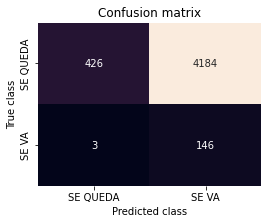

              precision    recall  f1-score   support

           0       0.99      0.09      0.17      4610
           1       0.03      0.98      0.07       149

    accuracy                           0.12      4759
   macro avg       0.51      0.54      0.12      4759
weighted avg       0.96      0.12      0.17      4759



In [70]:
ganancia, threshold = ThresholdOptimo(y_test_pb4, y_test)
print('\nGanancia Estimada: %.0f \nThreshold: %.4f\n' % (ganancia, threshold))

# Veo la matriz de confusión para el Threshlod seleccionado
# En y_test_pb1 = LOGR_model_no_bal.predict_proba(X_test)[:,1] tenemos la probabilidad
y_test_pp4 = (y_test_pb4 >= threshold).astype(bool)

Dibujar_MatrizConfusion(y_test, y_test_pp4)

In [71]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb3)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProb_RLOG_Bal3.xlsx')

In [72]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(lr3, path + '/RLOG_Bal3.joblib') 

['/content/drive/My Drive/B4/TPFinal/ML/RLOG_Bal3.joblib']

**Conclusión Regresión Logística - Modelo 4**

Viendo la Curva ROC y con un AUC-ROC en Test de 0,6323 no es un modelo apto para nuestra clasificación.

Ganancia Estimada: 342.100 - Threshold: 0,3062

**Conclusión General - Regresión Logística**

Para el conjunto de datos obtenido el modelo de Regresión Logística no es adecuado. Carece de robustez y confiabilidad en clasificación de los datos. 

# **Gradient Boosting**

Gradient Boosted Regression Trees es un método de ensemble donde se van construyendo árboles de decisión sencillos y se evalúan sus errorres. Posteriormente se vuelven a construir nuevos árboles pero mejorando la performance de los anteriores y así recurrentemente hasta tener un modelo completo. Es un método muy poderoso y ampliamente usado. Como contra tiene que hay que sintonizar muchos parámetros para que el modelo adquiera una performance óptima (con el consecuente tiempo de análisis y computacional).

## **Grid Search**

Uno de los requisitos del Gradient Boosting es sintonizar los parámetros principales para que el modelo adquiera una performance óptima.

En nuestro caso tomaremos como fijos los siguientes parámetros:
- `n_estimators`: **5000** Máximo número árboles en el modelo
- `validation_fraction`: **10%** de las observaciones serán usadas para validación
- `n_iter_no_change`: **20** criterio que para el training: si no se observaron cambios de performance en 20 iteraciones el training se para
- `max_features`: **log2(# features)** 

Como parámetros variables (se irán cambiando en sucesivos modelos en la Grilla):
- `learning_rate`: es el peso asignado a cada árbol de predicción construído. Ensayaremos los valores: [0.5, 0.3, 0.1]
- `max_depth`: máxima profundidad de los árboles contruídos en el modelo. Ensayaremos los valores: [2, 3, 5]
- `subsample`: porcentaje de observaciones que serán usadas para construir los árboles individuales. Ensayaremos los valores: [0.5, 0.8, 1]

Usaremos GradientBoostingClassifier con GridSeearchCV (con cross validation).

In [73]:
# Buscamos parámetros con Grid Search
parametros = {'learning_rate': [0.5, 0.3, 0.1], 'max_depth': [2, 3, 5], 'subsample': [0.5, 0.8, 1]}

grid = GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=5000, validation_fraction=0.1, n_iter_no_change=20, max_features='log2',
                      verbose=1, random_state=1, min_samples_split=500, min_samples_leaf=50), param_grid=parametros, scoring='roc_auc', cv=5)

grid.fit(X_train, y_train)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2531           0.0001           15.47s
         2           0.2621           0.0008           18.18s
         3           0.2319           0.0204           18.99s
         4           0.2588          -0.0005           18.17s
         5           0.2573          -0.0002           17.90s
         6           0.2220          -0.0001           17.51s
         7           0.2254          -0.0006           17.85s
         8           0.2362          -0.0012           17.95s
         9           0.2228          -0.0005           17.98s
        10           0.2347          -0.0002           17.80s
        20           0.1911           0.0011           16.64s
        30           0.1827          -0.0004           16.15s
        40           0.1504           0.0005           16.40s
        50           0.1572          -0.0006           15.96s
      Iter       Train Loss      OOB Improve   Remaining Time 
      

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='log2',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  n_estimators=5000,
                                                  n_iter_no_change=20,
                                                  random_state=1, verbose=1),
             param_grid={'learning_rate': [0.5, 0.3, 0.1],
                         'max_depth': [2, 3, 5], 'subsample': [0.5, 0.8, 1]},
             scoring='roc_auc')

In [74]:
print ('Best Score: {:.2f}', grid.best_score_)


Best Score: {:.2f} 0.8865782734549017


In [75]:
grid.best_params_


{'learning_rate': 0.3, 'max_depth': 2, 'subsample': 1}

## **Gradient Boost - Modelo 1 - Datos sin balancear**

Parámetros óptimos encontrados por GridSearch: {'learning_rate': 0.3, 'max_depth': 2, 'subsample': 1}

Utilizando estos parámetros óptimos entrenamos un modelo usando los datos originales sin balancear las clases.

In [76]:
# Con los parámetros anteriores entrenamos un GBoost
gbm1 = GradientBoostingClassifier(n_estimators=5000,
                                       learning_rate=0.3,
                                       max_depth=2,
                                       subsample=1,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       max_features='log2',
                                       verbose=1, random_state=1)
gbm1.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.2419           29.68s
         2           0.2411           28.53s
         3           0.2329           29.09s
         4           0.2242           29.65s
         5           0.2168           30.91s
         6           0.2106           31.31s
         7           0.2103           29.14s
         8           0.2098           27.79s
         9           0.2044           27.52s
        10           0.2042           26.71s
        20           0.1845           22.69s
        30           0.1728           21.27s
        40           0.1670           20.69s
        50           0.1646           20.48s
        60           0.1622           20.16s
        70           0.1603           19.96s
        80           0.1591           19.36s
        90           0.1581           19.09s


GradientBoostingClassifier(learning_rate=0.3, max_depth=2, max_features='log2',
                           n_estimators=5000, n_iter_no_change=20,
                           random_state=1, subsample=1, verbose=1)

In [77]:
len(gbm1.estimators_)


90

In [78]:
y_train_pb1 = gbm1.predict_proba(X_train)[:,1]
y_test_pb1 = gbm1.predict_proba(X_test)[:,1]

y_train_pred1 = gbm1.predict(X_train)
y_test_pred1 = gbm1.predict(X_test)

print("AUC Train: {:.4f}\nAUC Test: {:.4f} \n".format(roc_auc_score(y_train, y_train_pb1),
                                                    roc_auc_score(y_test, y_test_pb1)))

print('Accuracy: Train: %.4f - Test: %.4f' % (accuracy_score(y_train, y_train_pred1), accuracy_score(y_test, y_test_pred1)))
print('Recall: Train: %.4f - Test: %.4f' % (recall_score(y_train, y_train_pred1), recall_score(y_test, y_test_pred1)))
print('Precision: Train: %.4f - Test: %.4f' % (precision_score(y_train, y_train_pred1), precision_score(y_test, y_test_pred1)))

fpr_test1, tpr_test1, threshold1 = roc_curve(y_test, y_test_pb1)


AUC Train: 0.9239
AUC Test: 0.8741 

Accuracy: Train: 0.9728 - Test: 0.9670
Recall: Train: 0.0521 - Test: 0.0067
Precision: Train: 0.7778 - Test: 0.1000


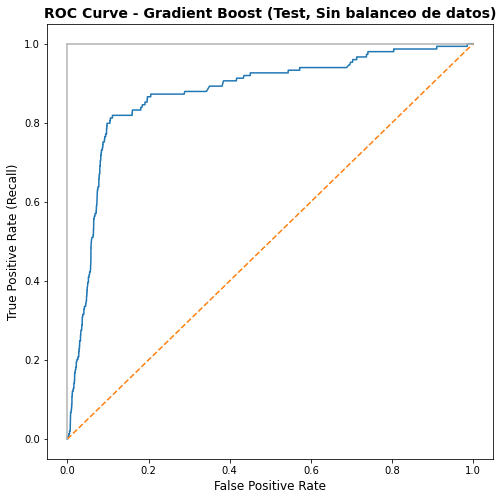

In [79]:
# Plot ROC curves
plt.subplots(1, figsize=(8, 8))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.title('ROC Curve - Gradient Boost (Test, Sin balanceo de datos)', fontsize=14, fontweight="bold")
plt.plot(fpr_test1, tpr_test1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.show()



Ganancia Estimada: 546600 
Threshold: 0.0209



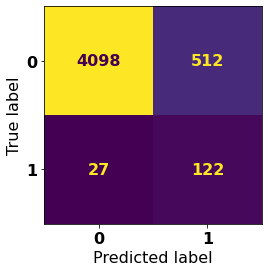

In [83]:
ganancia, threshold = ThresholdOptimo(y_test_pb1, y_test)
print('\nGanancia Estimada: %.0f \nThreshold: %.4f\n' % (ganancia, threshold))

# Veo la matriz de confusión para el Threshlod seleccionado
# En y_test_pb1 = gbm1.predict_proba(X_test)[:,1] tenemos la probabilidad
y_test_pp1 = (y_test_pb1 >= threshold).astype(bool)

plt.rcParams["figure.figsize"] = (4,4)
font = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16}
plt.rc('font', **font)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
ConfusionMatrixDisplay.from_predictions (y_test, y_test_pp1, labels=gbm1.classes_, colorbar=False, cmap='viridis')
plt.show()


In [ ]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb1)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProbBoostSB.xlsx')


In [ ]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(gbm1, path + '/GBoostSB.joblib') 


['/content/drive/My Drive/B4/TPFinal/ML/GBoostSB.joblib']

**Conclusión Gradient Boost - Modelo 1**

Viendo la Curva ROC y con un AUC-ROC en Test de 0,874 parece ser un modelo muy apto para nuestra clasificación.

Ganancia Estimada: 546.600 - Threshold: 0,0209

## **Grid Search (datos balanceados)**

Para tratar el DF con clases desbalanceadas usaremos la técnica de SMOTE que genera artificialmente elementos de la clase minoritaria hasta tener la misma cantidad de elementos que la clase mayoritaria, dejando el DF completamente balanceado. Utilizando los mismos parámetros óptimos anteriores entrenamos otro modelo usando los datos previamente balanceando las clases con SMOTE.

In [84]:
# import library
from collections import Counter
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(random_state=1)
X2_train, y2_train = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y2_train)
print(counter)

print(X2_train.shape)

Counter({0: 13872, 1: 13872})
(27744, 15)


Nuevamente hacemos un Grid Search, en este caso con datos previamente balancedos con SMOTE.

Usaremos GradientBoostingClassifier con GridSearchCV (con cross validation).

In [ ]:
# Buscamos parámetros con Grid Search
parametros = {'learning_rate': [0.5, 0.3, 0.1], 'max_depth': [2, 3, 5], 'subsample': [0.5, 0.8, 1]}

grid = GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=5000, validation_fraction=0.1, n_iter_no_change=20, max_features='log2',
                      verbose=1, random_state=1, min_samples_split=500, min_samples_leaf=50), param_grid=parametros, scoring='roc_auc', cv=5)

grid.fit(X2_train, y2_train)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3490           0.0355           56.47s
         2           1.3161           0.0337           59.06s
         3           1.3080           0.0106           54.73s
         4           1.1051           0.1977           55.71s
         5           0.9901           0.1105           55.48s
         6           0.9759           0.0145           53.85s
         7           0.9700           0.0098           52.12s
         8           0.8848           0.0942           52.45s
         9           0.8536           0.0139           51.46s
        10           0.8199           0.0444           52.13s
        20           0.6868           0.0121           51.78s
        30           0.6314           0.0022           52.10s
        40           0.5859           0.0002           52.23s
        50           0.5828           0.0004           50.86s
        60           0.5777           0.0002           50.01s
       

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='log2',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  n_estimators=5000,
                                                  n_iter_no_change=20,
                                                  random_state=1, verbose=1),
             param_grid={'learning_rate': [0.5, 0.3, 0.1],
                         'max_depth': [2, 3, 5], 'subsample': [0.5, 0.8, 1]},
             scoring='roc_auc')

In [ ]:
print ('Best Score: {:.2f}', grid.best_score_)


Best Score: {:.2f} 0.9799458450741396


In [ ]:
grid.best_params_


{'learning_rate': 0.3, 'max_depth': 5, 'subsample': 1}

## **Gradient Boost - Modelo 2 - Datos balanceados**

Parámetros óptimos encontrados por GridSearch: {'learning_rate': 0.3, 'max_depth': 5, 'subsample': 1}

Utilizando estos parámetros óptimos entrenamos un modelo usando los datos previamente balancedos con SMOTE.

In [85]:
# Con los parámetros anteriores entrenamos un GBoost
gbm2 = GradientBoostingClassifier(n_estimators=5000,
                                       learning_rate=0.3,
                                       max_depth=5,
                                       subsample=1,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       max_features='log2',
                                       verbose=1, random_state=1)
gbm2.fit(X2_train, y2_train)


      Iter       Train Loss   Remaining Time 
         1           1.1123            1.78m
         2           1.0111            1.64m
         3           0.9353            1.56m
         4           0.8779            1.54m
         5           0.7885            1.58m
         6           0.7512            1.59m
         7           0.7366            1.54m
         8           0.7259            1.50m
         9           0.6794            1.53m
        10           0.6662            1.51m
        20           0.5461            1.39m
        30           0.4913            1.30m
        40           0.4449            1.31m
        50           0.4156            1.28m
        60           0.3927            1.25m
        70           0.3756            1.22m
        80           0.3615            1.21m
        90           0.3483            1.20m
       100           0.3367            1.19m
       200           0.2493            1.15m
       300           0.1937            1.11m


GradientBoostingClassifier(learning_rate=0.3, max_depth=5, max_features='log2',
                           n_estimators=5000, n_iter_no_change=20,
                           random_state=1, subsample=1, verbose=1)

In [86]:
len(gbm2.estimators_)


348

In [87]:
y_train_pb2 = gbm2.predict_proba(X2_train)[:,1]
y_test_pb2 = gbm2.predict_proba(X_test)[:,1]

y_train_pred2 = gbm2.predict(X2_train)
y_test_pred2 = gbm2.predict(X_test)

print("AUC Train: {:.4f}\nAUC Test: {:.4f} \n".format(roc_auc_score(y2_train, y_train_pb2),
                                                    roc_auc_score(y_test, y_test_pb2)))

print('Accuracy: Train: %.4f - Test: %.4f' % (accuracy_score(y2_train, y_train_pred2), accuracy_score(y_test, y_test_pred2)))
print('Recall: Train: %.4f - Test: %.4f' % (recall_score(y2_train, y_train_pred2), recall_score(y_test, y_test_pred2)))
print('Precision: Train: %.4f - Test: %.4f' % (precision_score(y2_train, y_train_pred2), precision_score(y_test, y_test_pred2)))

fpr_test2, tpr_test2, threshold2 = roc_curve(y_test, y_test_pb2)


AUC Train: 0.9938
AUC Test: 0.7620 

Accuracy: Train: 0.9712 - Test: 0.9092
Recall: Train: 0.9862 - Test: 0.4094
Precision: Train: 0.9575 - Test: 0.1506


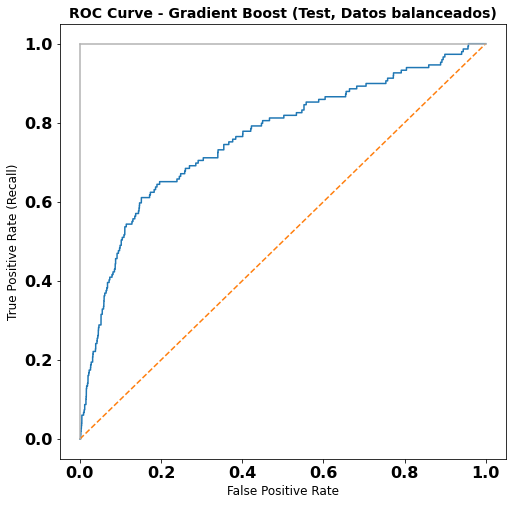

In [88]:
# Plot ROC curves
plt.subplots(1, figsize=(8, 8))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.title('ROC Curve - Gradient Boost (Test, Datos balanceados)', fontsize=14, fontweight="bold")
plt.plot(fpr_test2, tpr_test2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.show()



Ganancia Estimada: 384700 
Threshold: 0.0699



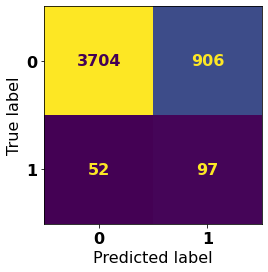

In [89]:
ganancia, threshold = ThresholdOptimo(y_test_pb2, y_test)
print('\nGanancia Estimada: %.0f \nThreshold: %.4f\n' % (ganancia, threshold))

# Veo la matriz de confusión para el Threshlod seleccionado
# En y_test_pb2 = gbm2.predict_proba(X_test)[:,1] tenemos la probabilidad
y_test_pp2 = (y_test_pb2 >= threshold).astype(bool)

plt.rcParams["figure.figsize"] = (4,4)
font = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16}
plt.rc('font', **font)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
ConfusionMatrixDisplay.from_predictions (y_test, y_test_pp2, labels=gbm2.classes_, colorbar=False, cmap='viridis')
plt.show()


In [ ]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb2)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProbBoostBal.xlsx')


In [ ]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(gbm2, path + '/GBoostBal.joblib') 


['/content/drive/My Drive/B4/TPFinal/ML/GBoostBal.joblib']

**Conclusión Gradient Boost - Modelo 2**

Viendo la Curva ROC y con un AUC-ROC en Test de 0,762 indica que este modelo clasifica de peor manera que el anterior.

Ganancia Estimada: 384.700 - Threshold: 0,0699

## **Random Forest (Balanceado)**

Vamos a entrenar un Random Forest. Para trabajar con el DF con clases desbalanceadas usaremos el parámetro **class_weight** del clasificador. Con **class_weight='balanced'** el clasificador ve los valores de y_train y ajustará el peso de cada clase de forma inversamente proporcional a la cantidad encontrada de cada clase según la fórmula: wj = n_samples / (n_classes * n_samplesj).


En nuestro Train set tenemos: Total: 14.275, Clase 0: 13.872, Clase 1: 403 (2,8%)
Weights (peso) Clase 0: w0 = 14.275 / (2 * 13.872) = 0,515
Weights (peso) Clase 1: w1 = 14.275 / (2 * 403) = 17,711

Dicho de otro modo: el clasificador le asignará mucha más importancia a las muestras con clase minoritaria en 34 veces más. Es equivalente a poner **class_weight={0: 0.52, 1: 17.71}**.

In [90]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=5, class_weight='balanced', max_leaf_nodes=16, n_jobs=-1, random_state=1)
rnd_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, max_leaf_nodes=16,
                       n_estimators=500, n_jobs=-1, random_state=1)

In [91]:
y_train_pb3 = rnd_clf.predict_proba(X_train)[:,1]
y_test_pb3 = rnd_clf.predict_proba(X_test)[:,1]

y_train_pred3 = rnd_clf.predict(X_train)
y_test_pred3 = rnd_clf.predict(X_test)

print("AUC Train: {:.4f}\nAUC Test: {:.4f} \n".format(roc_auc_score(y_train, y_train_pb3),
                                                    roc_auc_score(y_test, y_test_pb3)))

print('Accuracy: Train: %.4f - Test: %.4f' % (accuracy_score(y_train, y_train_pred3), accuracy_score(y_test, y_test_pred3)))
print('Recall: Train: %.4f - Test: %.4f' % (recall_score(y_train, y_train_pred3), recall_score(y_test, y_test_pred3)))
print('Precision: Train: %.4f - Test: %.4f' % (precision_score(y_train, y_train_pred3), precision_score(y_test, y_test_pred3)))

fpr_test3, tpr_test3, threshold3 = roc_curve(y_test, y_test_pb3)


AUC Train: 0.9114
AUC Test: 0.8637 

Accuracy: Train: 0.8353 - Test: 0.8300
Recall: Train: 0.8759 - Test: 0.7987
Precision: Train: 0.1330 - Test: 0.1325


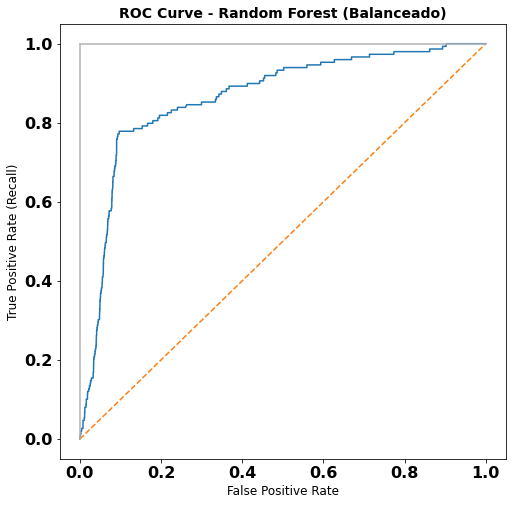

In [92]:
# Plot ROC curves
plt.subplots(1, figsize=(8, 8))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.title('ROC Curve - Random Forest (Balanceado)', fontsize=14, fontweight="bold")
plt.plot(fpr_test3, tpr_test3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.show()



Ganancia Estimada: 523700 
Threshold: 0.5560



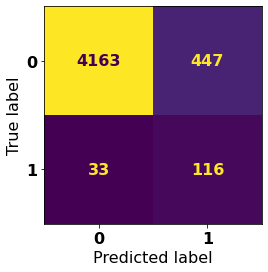

In [93]:
ganancia, threshold = ThresholdOptimo(y_test_pb3, y_test)
print('\nGanancia Estimada: %.0f \nThreshold: %.4f\n' % (ganancia, threshold))

# Veo la matriz de confusión para el Threshlod seleccionado
# En y_test_pb3 = rnd_clf.predict_proba(X_test)[:,1] tenemos la probabilidad
y_test_pp3 = (y_test_pb3 >= threshold).astype(bool)

plt.rcParams["figure.figsize"] = (4,4)
font = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16}
plt.rc('font', **font)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
ConfusionMatrixDisplay.from_predictions (y_test, y_test_pp3, labels=rnd_clf.classes_, colorbar=False, cmap='viridis')
plt.show()


In [ ]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb3)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProbRFBal.xlsx')


In [ ]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(rnd_clf, path + '/RFBal.joblib') 


['/content/drive/My Drive/B4/TPFinal/ML/RFBal.joblib']

Veremos qué columnas considera el modelo Random Forest como más importantes en el análisis.

<Figure size 288x288 with 0 Axes>

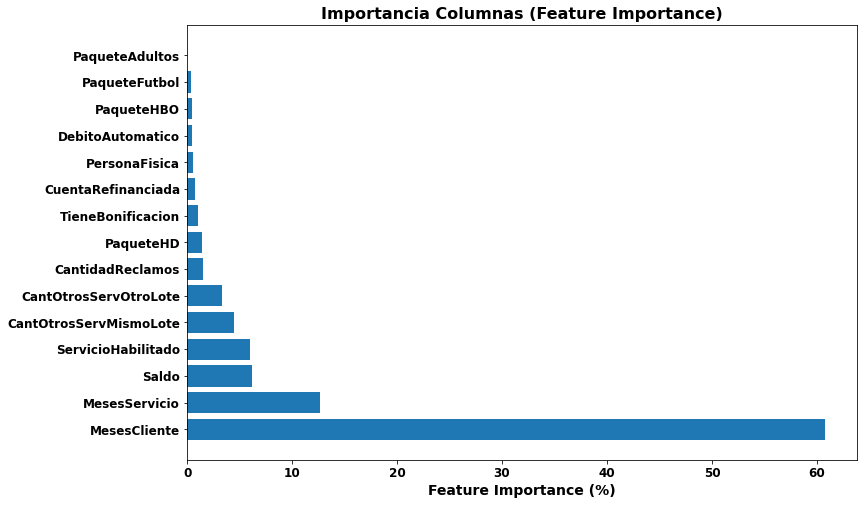

In [94]:
importancia = rnd_clf.feature_importances_
listacol = X.columns.tolist()

# Se arma un DF
dfc = pd.DataFrame(listacol)
dff = pd.DataFrame(importancia * 100)
dff = dff.reset_index()
dff = dff.drop(['index'], axis=1)
dfcf = pd.concat([dfc, dff], axis=1)
dfcf.columns = ['Columna', 'Importancia']
dfcf['Importancia'] = dfcf['Importancia'].round(2)
# Ordeno la columna de importancia de mayor a menor
dfcf = dfcf.sort_values('Importancia', ascending=False)
dfcf = dfcf.reset_index()

# Se grafican barras horizontales
x1_val = dfcf['Columna']
y1_val = dfcf['Importancia']

fig1 = plt.figure()
fig1, ax1 = plt.subplots(1, 1,figsize=(12, 8))
ax1.barh(x1_val, y1_val)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.set_xlabel('Feature Importance (%)', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'k'})
ax1.set_title('Importancia Columnas (Feature Importance)', loc = "center", fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'k'})
plt.show()


In [95]:
# Verificamos en las dos columnas más importantes para el modelo que datos tenemos
# Tomamos el DF completo df2 (Train + Test)
# Ahora evaluamos con Clase 0 y Clase 1
dfcl0 = df2[df2['target_bin']==0]
dfcl1 = df2[df2['target_bin']==1]

promcliente0 = dfcl0['MesesCliente'].mean()
promservicio0 = dfcl0['MesesServicio'].mean()
promcliente1 = dfcl1['MesesCliente'].mean()
promservicio1 = dfcl1['MesesServicio'].mean()

print ('MesesCliente Promedio Clase 0: %.2f' % promcliente0)
print ('MesesCliente Promedio Clase 1: %.2f' % promcliente1)
print()
print ('MesesServicio Promedio Clase 0: %.2f' % promservicio0)
print ('MesesServicio Promedio Clase 1: %.2f' % promservicio1)


MesesCliente Promedio Clase 0: 151.18
MesesCliente Promedio Clase 1: 88.36

MesesServicio Promedio Clase 0: 42.14
MesesServicio Promedio Clase 1: 41.85


Verificamos que el clasificador toma como columna principal para separar las clases a MesesCliente, que es la antigüedad del cliente medida en meses. Vemos que el promedio de MesesCliente de la Clase 0 (los clientes que se quedan en el servicio) es casi el doble que los de la Clase 1 (los que se van). No se verifica esta diferencia en la segunda columna tomada como importante (MesesServicio) donde ambos promedios son muy parecidos.

**Conclusión Random Forest Balanceado**

Viendo la Curva ROC y con un AUC-ROC en Test de 0,864 indica que es un buen modelo.

Ganancia Estimada: 523.700 - Threshold: 0,5560

## **Random Forest (Cost Sensitive Learning)**

Podemos también tratar las clases desbalanceadas usando el parámetro **class_weight** del clasificador pero indicando manualmente los pesos para cada clase con la técnica de **Cost Sensitive Learning**. Esta técnica implica asignar los pesos de cada clase basados en la matriz de costo. De esta manera se le está diciendo al clasificador cuánto es el costo de una clasificación errónea (que es muy diferente para cada clase). Así el clasificador buscará minimizar ese costo asociado al error de clasificación. En nuestro caso tenemos como matriz de costo: Clase = 1 suma 4900, Clase = 0 resta 100. Así ponemos esa diferencia de valores en el parámetro: **class_weight={0:1, 1:50}**. Vemos que es muy similar al ejemplo anterior (34 a 1) por lo que no se justifica utilizarlo.

## **Arbol de decisión**

Vamos a entrenar un árbol de decisión sencillo e intentaremos ver qué lógica sigue para separar las Clases.

## **Grid Search**

Vamos a sintonizar los parámetros principales del Arbol de Decisión para optimizar el modelo.

En nuestro caso tomaremos como fijos los siguientes parámetros:
- `class_weight`: **balanced** Para DF desbalanceados

Como parámetros variables (se irán cambiando en sucesivos modelos en la Grilla):
- `criterion`: es el criterio de evaluación que se hace en cada decisión. Ensayaremos los dos criterios posibles: ['gini', 'entropy']
- `max_depth`: máxima profundidad del árbol contruído en el modelo. Ensayaremos los valores: [3, 4, 5, 6, 7, 8, 9]

Usaremos DecisionTreeClassifier con GridSeearchCV (con cross validation).

In [ ]:
# Buscamos parámetros con Grid Search
parametros = {'criterion':['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': np.arange(3, 10)}

grid = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced', min_samples_split=5, min_samples_leaf=3,
                      random_state=1), param_grid=parametros, scoring='roc_auc', cv=5)

grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              min_samples_leaf=3,
                                              min_samples_split=5,
                                              random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print ('Best Score: {:.2f}', grid.best_score_)


Best Score: {:.2f} 0.8835237338034982


In [ ]:
grid.best_params_


{'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}

## **Decision Tree - Datos balanceados**

Parámetros óptimos encontrados por GridSearch: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4}

Utilizando estos parámetros óptimos entrenamos en modelo.

In [96]:
tree_clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, class_weight='balanced', min_samples_leaf=3,
                                  min_samples_split=5, random_state=1)
tree_clf.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=3,
                       min_samples_split=5, random_state=1)

In [97]:
y_train_pb4 = tree_clf.predict_proba(X_train)[:,1]
y_test_pb4 = tree_clf.predict_proba(X_test)[:,1]

y_train_pred4 = tree_clf.predict(X_train)
y_test_pred4 = tree_clf.predict(X_test)

print("AUC Train: {:.4f}\nAUC Test: {:.4f} \n".format(roc_auc_score(y_train, y_train_pb4),
                                                    roc_auc_score(y_test, y_test_pb4)))

print('Accuracy: Train: %.4f - Test: %.4f' % (accuracy_score(y_train, y_train_pred4), accuracy_score(y_test, y_test_pred4)))
print('Recall: Train: %.4f - Test: %.4f' % (recall_score(y_train, y_train_pred4), recall_score(y_test, y_test_pred4)))
print('Precision: Train: %.4f - Test: %.4f' % (precision_score(y_train, y_train_pred4), precision_score(y_test, y_test_pred4)))

fpr_test4, tpr_test4, threshold4 = roc_curve(y_test, y_test_pb4)


AUC Train: 0.9024
AUC Test: 0.8695 

Accuracy: Train: 0.8841 - Test: 0.8804
Recall: Train: 0.8685 - Test: 0.8121
Precision: Train: 0.1793 - Test: 0.1828


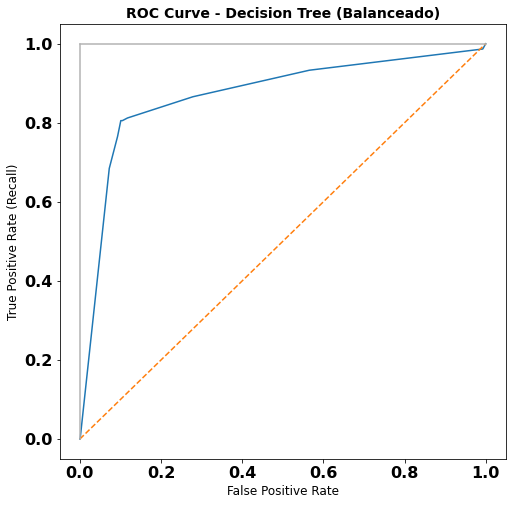

In [98]:
# Plot ROC curves
plt.subplots(1, figsize=(8, 8))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.title('ROC Curve - Decision Tree (Balanceado)', fontsize=14, fontweight="bold")
plt.plot(fpr_test4, tpr_test4)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.show()



Ganancia Estimada: 541500 
Threshold: 0.8155



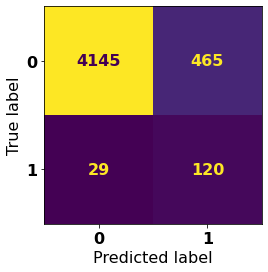

In [99]:
ganancia, threshold = ThresholdOptimo(y_test_pb4, y_test)
print('\nGanancia Estimada: %.0f \nThreshold: %.4f\n' % (ganancia, threshold))

# Veo la matriz de confusión para el Threshlod seleccionado
y_test_pp4 = (y_test_pb4 >= threshold).astype(bool)

plt.rcParams["figure.figsize"] = (4,4)
font = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16}
plt.rc('font', **font)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
ConfusionMatrixDisplay.from_predictions (y_test, y_test_pp4, labels=tree_clf.classes_, colorbar=False, cmap='viridis')
plt.show()


In [ ]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb4)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProbTree.xlsx')


In [ ]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(tree_clf, path + '/Tree.joblib') 


['/content/drive/My Drive/B4/TPFinal/ML/Tree.joblib']

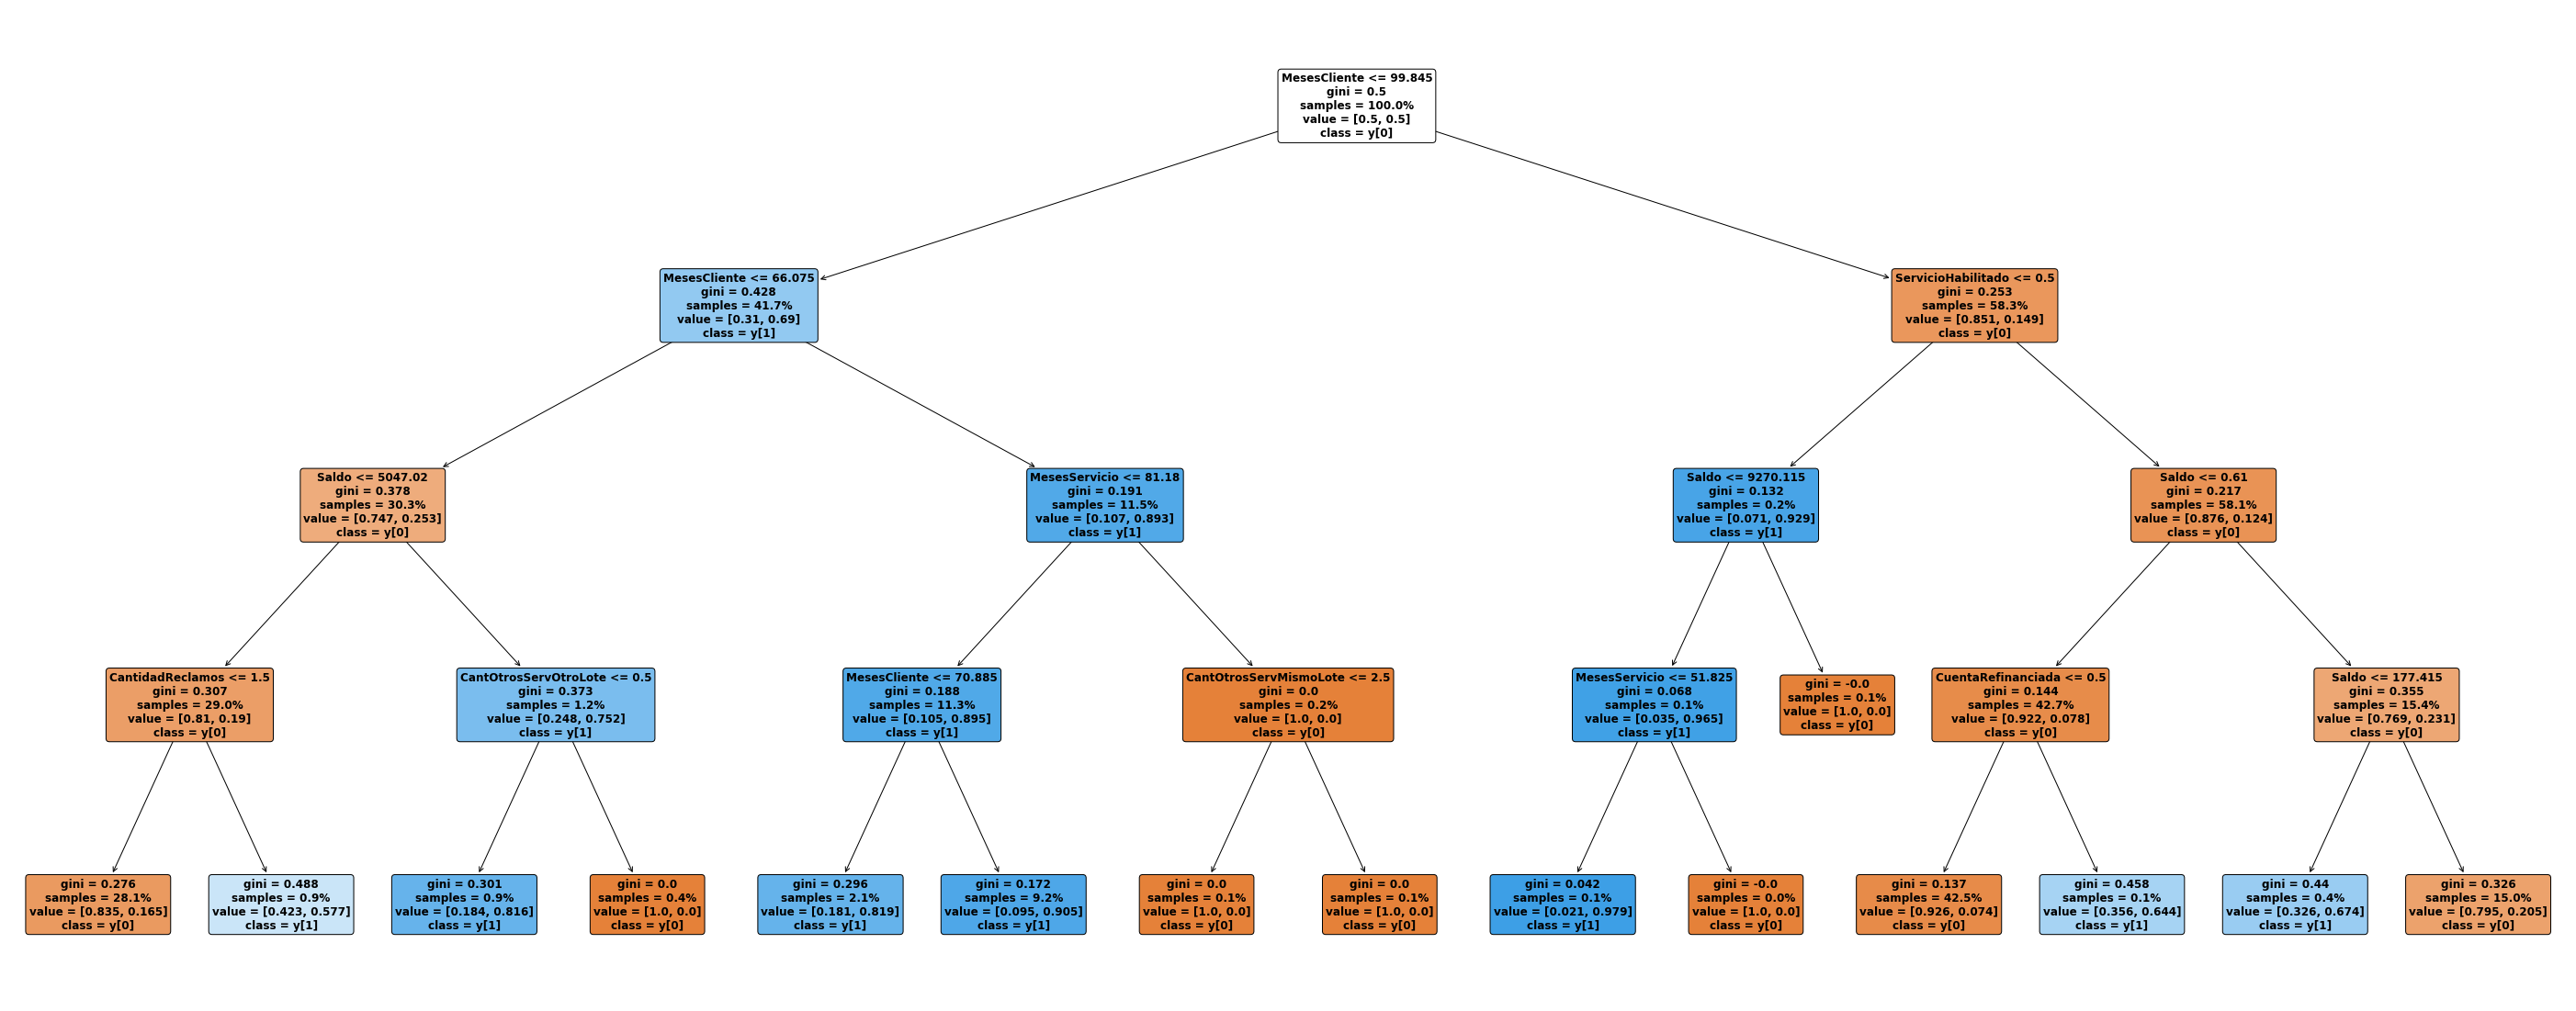

In [100]:
# Visualización Decision Tree
listacol = X.columns.tolist()
fig = plt.figure(figsize=(50,20))
_ = tree.plot_tree(tree_clf, feature_names=listacol, class_names=True, filled=True, proportion=True, rounded=True, fontsize=12)

En el diagrama del Decision Tree vemos que, al igual que Random Forest, el clasificador toma como columna principal a MesesCliente. En adelante (en orden de importancia) MesesServicio, ServicioHabilitado, Saldo, etc. de manera similar al Random Forest. 

**Conclusión Decision Tree Balanceado**

Viendo la Curva ROC y con un AUC-ROC en Test de 0,87 indica que es uno de los mejores modelos obtenidos.

Ganancia Estimada: 541.500 - Threshold: 0,8155

## **Gradient Boost - Modelo 3 - Datos sin balancear (TPOT)**

Hicimos una corrida con TPOT (Machine Learning automático, ver al final del notebook) y nos sugiere como mejor estimador:

GradientBoostingClassifier (input_matrix, learning_rate=0.001, max_depth=7, max_features=0.9, min_samples_leaf=10, min_samples_split=15, n_estimators=100, subsample=0.65)

Utilizando estos parámetros óptimos entrenamos un modelo usando los datos originales sin balancear las clases.

In [101]:
# Con los parámetros anteriores entrenamos un GBoost
gbm3 = GradientBoostingClassifier(n_estimators=100,
                                       learning_rate=0.001,
                                       max_depth=7,
                                       subsample=0.65,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       max_features=0.9, min_samples_leaf=10, min_samples_split=15,
                                       verbose=1, random_state=1)
gbm3.fit(X_train, y_train)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2653           0.0003            1.98s
         2           0.2540           0.0003            2.06s
         3           0.2545           0.0003            1.97s
         4           0.2582           0.0003            1.94s
         5           0.2445           0.0003            1.95s
         6           0.2634           0.0003            1.92s
         7           0.2538           0.0003            1.90s
         8           0.2726           0.0003            1.86s
         9           0.2555           0.0003            1.84s
        10           0.2552           0.0003            1.84s
        20           0.2756           0.0002            1.61s
        30           0.2411           0.0003            1.40s
        40           0.2396           0.0002            1.21s
        50           0.2393           0.0002            1.00s
        60           0.2455           0.0002            0.80s
       

GradientBoostingClassifier(learning_rate=0.001, max_depth=7, max_features=0.9,
                           min_samples_leaf=10, min_samples_split=15,
                           n_iter_no_change=20, random_state=1, subsample=0.65,
                           verbose=1)

In [102]:
len(gbm3.estimators_)


100

In [103]:
y_train_pb5 = gbm3.predict_proba(X_train)[:,1]
y_test_pb5 = gbm3.predict_proba(X_test)[:,1]

y_train_pred5 = gbm3.predict(X_train)
y_test_pred5 = gbm3.predict(X_test)

print("AUC Train: {:.4f}\nAUC Test: {:.4f} \n".format(roc_auc_score(y_train, y_train_pb5),
                                                    roc_auc_score(y_test, y_test_pb5)))

print('Accuracy: Train: %.4f - Test: %.4f' % (accuracy_score(y_train, y_train_pred5), accuracy_score(y_test, y_test_pred5)))
print('Recall: Train: %.4f - Test: %.4f' % (recall_score(y_train, y_train_pred5), recall_score(y_test, y_test_pred5)))
print('Precision: Train: %.4f - Test: %.4f' % (precision_score(y_train, y_train_pred5), precision_score(y_test, y_test_pred5)))

fpr_test5, tpr_test5, threshold5 = roc_curve(y_test, y_test_pb5)


AUC Train: 0.9487
AUC Test: 0.8879 

Accuracy: Train: 0.9718 - Test: 0.9687
Recall: Train: 0.0000 - Test: 0.0000
Precision: Train: 0.0000 - Test: 0.0000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


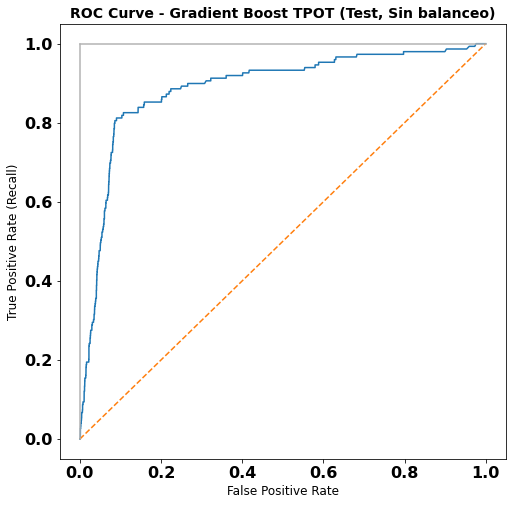

In [104]:
# Plot ROC curves
plt.subplots(1, figsize=(8, 8))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.title('ROC Curve - Gradient Boost TPOT (Test, Sin balanceo)', fontsize=14, fontweight="bold")
plt.plot(fpr_test5, tpr_test5)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.show()



Ganancia Estimada: 553200 
Threshold: 0.0290



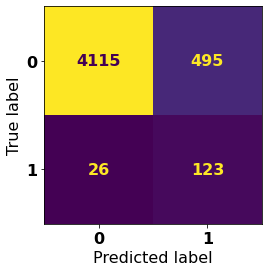

In [105]:
ganancia, threshold = ThresholdOptimo(y_test_pb5, y_test)
print('\nGanancia Estimada: %.0f \nThreshold: %.4f\n' % (ganancia, threshold))

# Veo la matriz de confusión para el Threshlod seleccionado
y_test_pp5 = (y_test_pb5 >= threshold).astype(bool)

plt.rcParams["figure.figsize"] = (4,4)
font = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16}
plt.rc('font', **font)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
ConfusionMatrixDisplay.from_predictions (y_test, y_test_pp5, labels=gbm3.classes_, colorbar=False, cmap='viridis')
plt.show()


In [ ]:
# Guardo la tabla de probabilidades contra la clase real por si necesito verla en Excel
dfp = pd.DataFrame(y_test_pb5)
dfy = pd.DataFrame(y_test)
dfy = dfy.reset_index()
dfy = dfy.drop(['index'], axis=1)
dfpmodelo = pd.concat([dfy, dfp], axis=1)
dfpmodelo.columns = ['Clase', 'Probabilidad']
dfpmodelo.to_excel(path + '/TablaProbBoostTPOT.xlsx')


In [ ]:
# Salvo el modelo en disco para levantarlo luego
from joblib import dump, load
dump(gbm3, path + '/GBoostTPOT.joblib') 


['/content/drive/My Drive/B4/TPFinal/ML/GBoostTPOT.joblib']

**Conclusión Gradient Boost - Modelo 3 (TPOT)**

Es el mejor modelo encontrado, con Curva ROC y con un AUC-ROC en Test de 0,888.

Ganancia Estimada: 553.200 - Threshold: 0,0290

## **Ensemble de Modelos**

Vamos a tomar los 3 modelos más logrados y los pondremos en un Ensemble:


*   Gradient Boost TPOT, GBoostTPOT.joblib, Theshold: 0,0290
*   Decision Tree, Tree.joblib, Theshold: 0,8155
*   Random Forest, RFBal.joblib, Theshold: 0,8637

Usaremos la técnica de 'Hard Voting': en cada elemento la decisión será tomada por la mayoría de los 3 clasificadores. 

In [107]:
# En y_test_pp5 tengo la clasificación del Gradient Boost TPOT
# En y_test_pp4 tengo la clasificación del Decision Tree
# En y_test_pp3 tengo la clasificación del Random Forest
dfensemble = pd.DataFrame({'GBoost':y_test_pp5, 'Tree':y_test_pp4, 'RForest':y_test_pp3})

# Se hace el Hard Voting con la Moda de cada fila
y_test_pp6 = dfensemble.mode(axis=1)

# Se genera una columna Voting
dfensemble['Voting'] = dfensemble.mode(axis=1)
dfensemble.head()


,GBoost,Tree,RForest,Voting
0,False,False,False,False
1,True,True,True,True
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False


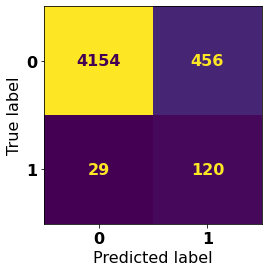

In [108]:
plt.rcParams["figure.figsize"] = (4,4)
font = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16}
plt.rc('font', **font)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
ConfusionMatrixDisplay.from_predictions (y_test, y_test_pp6, labels=gbm3.classes_, colorbar=False, cmap='viridis')
plt.show()


In [109]:
# Ganacia estimada con Ensemble
gan = 118 * 4900 - 446 * 100
print('\nGanancia Estimada: %.0f \n' % (gan))



Ganancia Estimada: 533600 



**Conclusión Ensemble**

El Ensemble de varios modelos da una ganancia menor que el mejor de los modelos individuales pero debe ser tenido en cuenta ya que, al tomar las fortalezas de cada uno de los modelos involucrados, obtiene una mayor robustez y, probablemente, generalice mejor (minimizando el overfitting).

Ganancia Estimada: 533.600

## **Modelos ML - Conclusión final**

De todos los modelos entrenados tenemos varios modelos con métricas muy buenas. Listaremos los mejores en orden descendente por ganancia prevista.

1.   Gradient Boost 3 TPOT: 553.200 (Threshold: 0,0290)
2.   Gradient Boost 1: 546.600 (Threshold: 0,0209)
3.   Decision Tree: 541.500 (Threshold: 0,8155)
4.   Ensemble: 533.600
5.   Random Forest: 523.700 (Threshold: 0,5560)

Para implementar en producción se eligen:
1.   Gradient Boost 3 TPOT: da la mayor ganancia estimada y es el mejor modelo obtenido (AUC ROC = 0,888).
2.   Decision Tree: da una muy buena performance y es muy fácil de interpretar su lógica de acción dándonos un mapa para dónde actuar.
3.   Ensemble: tiene también muy buena performance y puede generalizar mejor que los modelos anteriores.











-----------------------------------------------------

## **AutoML: TPOT**

Vamos a utilizar una herramienta de Auto Machine Learning (TPOT) que estudiará el DF en diferentes clasificadores y parámetros y nos devolverá la mejor solución encontrada.


In [ ]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.0 MB/s 
     |████████████████████████████████| 139 kB 30.4 MB/s 
     |████████████████████████████████| 193.6 MB 68 kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11953 sha256=fe2d1bb0bb1c90062adc9ab412bd3d05f35b1b5b1dcfcc954306bcb4d33df03c
  Stored in directory: /root/.cache/pip/wheels/a8/bb/8f/6b9328d23c2dcedbfeb8498b9f650d55d463089e3b8fc0bfb2
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
from sklearn.metrics import make_scorer
from tpot import TPOTClassifier

In [ ]:
#Usamos el DF con los Registros Balanceados - Con Scorer ROC_AUC
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, n_jobs=-1, random_state=1,
                      scoring="roc_auc", max_time_mins=60)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8910710354310091

Generation 2 - Current best internal CV score: 0.8910710354310091

Generation 3 - Current best internal CV score: 0.8910710354310091

Generation 4 - Current best internal CV score: 0.8910710354310091

Generation 5 - Current best internal CV score: 0.8924861720889359

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.001, max_depth=7, max_features=0.9000000000000001, min_samples_leaf=10, min_samples_split=15, n_estimators=100, subsample=0.6500000000000001)
0.8900464412060154


**Conclusión AutoML (TPOT)**

El mejor modelo encontrado por TPOT es:

GradientBoostingClassifier (input_matrix, learning_rate=0.001, max_depth=7, max_features=0.9, min_samples_leaf=10, min_samples_split=15, n_estimators=100, subsample=0.65)

Lo usaremos como modelo válido (ver Gradient Boost - Modelo 3)